In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv

import scipy

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
%matplotlib inline

In [4]:
print(nib.__version__, nilearn.__version__, nitime.__version__, scipy.__version__)

2.4.1 0.5.2 0.8.1 1.3.0


### Test the confounds file exists

In [ ]:
confounds_file = "/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-mp_run-02_desc-confounds_regressors.tsv"

In [ ]:
confounds_df = pd.read_csv(confounds_file, sep=str('\t'), na_values="n/a")

In [ ]:
confounds_df.head()

In [ ]:
poss_confounds = list(confounds_df.columns)
poss_confounds[:5]

### Define paths etc

In [35]:
sub = "NB"
ses = "20191221"

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/")
derivs_dir = os.path.abspath('/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams')
out_dir = os.path.abspath(f"{derivs_dir}/sub-{sub}")
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
ref_vol_name = f"sub-{sub}_ses-{ses}_ref_vol"
ref_vol_path = os.path.abspath(f"{out_dir}/{ref_vol_name}.nii.gz")
mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_mask.nii.gz")
coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-coherence_map.nii")

#### For testing BIDS names

In [27]:
utils.isBIDSFile(mask_file)
utils.isBIDSFile(coh_fn)
utils.isBIDSFile(ref_vol_path)

sub-NB_ses-20191221_mask.nii.gz True
sub-NB_ses-20191221_task-hemi_desc-coherence_map.nii True
sub-NB_ses-20191221_ref_vol.nii False


False

#### Make ref_vol from first dicom

In [28]:
first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun\ -\ 1/sb_bold_1p75mmISO_PSN_5/IM-0005-0001.dcm"
# first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun - 1/sb_bold_1p75mmISO_PSN_6/IM-0006-0001.dcm"

In [29]:
!ls {first_dicom}

/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun - 1/sb_bold_1p75mmISO_PSN_5/IM-0005-0001.dcm


In [30]:
!pwd

/Users/smerdis/code/coupling/streams/glm_code


In [31]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {ref_vol_name} -z y -o {out_dir} {first_dicom}"
print(dcm2niix_cmd)
os.system(dcm2niix_cmd)

dcm2niix -v 2 -s y -f sub-NB_ses-20191221_ref_vol -z y -o /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB /Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun\ -\ 1/sb_bold_1p75mmISO_PSN_5/IM-0005-0001.dcm


0

In [11]:
!ls {out_dir}

ref_vol.json ref_vol.nii


#### mcflirt the bold files using ref_vol as the reference image, save them as _preproc

In [17]:
from bids import BIDSLayout
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
raw_bolds = sorted([f for f in raw_layout.get(subject=sub, session=ses, suffix='bold',
            extension=['nii.gz'], return_type='file')])

In [18]:
print("\n".join(raw_bolds))

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-01_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-02_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-03_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-04_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-05_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-06_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-2019

In [26]:
ref_vol_path = os.path.join(out_dir, ref_vol_name)
for this_epi in raw_bolds:
    epi_name = os.path.basename(this_epi)
    epi_stub = epi_name.split('.')[0]
    epi_stub_parts = epi_stub.split('_')
    epi_stub_parts.insert(-1, 'desc-preproc')
    epi_stub_mcf = '_'.join(epi_stub_parts)
    full_outpath = os.path.join(out_dir, f"sub-{sub}", f"ses-{ses}", "func", epi_stub_mcf)
    mcflirt_cmd = f"mcflirt -reffile {ref_vol_path} -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

mcflirt -reffile /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/ref_vol -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_desc-preproc_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/ref_vol -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/ref_vol -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses

In [25]:
!ls /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/

ls: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/: No such file or directory


#### Move event and json files

In [6]:
events_glob = f"{raw_data_dir}/ses-{ses}/func/*events*.tsv"
print("\n".join(glob.glob(events_glob)))
task_json_glob = f"{raw_data_dir}/ses-{ses}/func/*task*json"
print("\n".join(glob.glob(task_json_glob)))

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-05_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-08_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-02_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-07_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-04_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-01_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/fun

### Write hemifield event files (they are all identical)

In [33]:
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-01_events.tsv")
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-02_events.tsv")

297.0 6.0 132.0
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_events.tsv
onset	duration	trial_type
0.0	13.5	R
13.5	13.5	L
27.0	13.5	R
40.5	13.5	L
54.0	13.5	R
67.5	13.5	L
81.0	13.5	R
94.5	13.5	L
108.0	13.5	R
121.5	13.5	L
135.0	13.5	R
148.5	13.5	L
162.0	13.5	R
175.5	13.5	L
189.0	13.5	R
202.5	13.5	L
216.0	13.5	R
229.5	13.5	L
243.0	13.5	R
256.5	13.5	L
270.0	13.5	R

297.0 6.0 132.0
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_events.tsv
onset	duration	trial_type
0.0	13.5	R
13.5	13.5	L
27.0	13.5	R
40.5	13.5	L
54.0	13.5	R
67.5	13.5	L
81.0	13.5	R
94.5	13.5	L
108.0	13.5	R
121.5	13.5	L
135.0	13.5	R
148.5	13.5	L
162.0	13.5	R
175.5	13.5	L
189.0	13.5	R
202.5	13.5	L
216.0	13.5	R
229.5	13.5	L
243.0	13.5	R
256.5	13.5	L
270.0	13.5	R



In [34]:
!cat /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_events.tsv


onset	duration	trial_type
0.0	13.5	R
13.5	13.5	L
27.0	13.5	R
40.5	13.5	L
54.0	13.5	R
67.5	13.5	L
81.0	13.5	R
94.5	13.5	L
108.0	13.5	R
121.5	13.5	L
135.0	13.5	R
148.5	13.5	L
162.0	13.5	R
175.5	13.5	L
189.0	13.5	R
202.5	13.5	L
216.0	13.5	R
229.5	13.5	L
243.0	13.5	R
256.5	13.5	L
270.0	13.5	R


In [32]:
for e in glob.glob(events_glob):
    fileparts = op.split(e)[-1].split('_')[:-1]
    fileparts[0] = f"sub-{sub}"
    #runpart = fileparts[-2]
    #print('_'.join(fileparts), fileparts[-2])
    fn = '_'.join(fileparts)
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}.tsv"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-nb_ses-20191221_task-mp_run-08_events_1529.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-08_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-nb_ses-20191221_task-mp_run-37_events_1523.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-37_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-nb_ses-20191221_task-mp_run-02_events_1451.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-02_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-05_events.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-05.tsv
/Users/smerdis/data/LGN/BIDS/NB_20191221/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_ru

In [ ]:

for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [36]:
blocks_in_order = ['L', 'R']
for thisrun in [1]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    #with open(events_fn, 'w') as f:
        #f.write(events_file_contents)
    print(events_fn, '\n', events_file_contents)

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_events.tsv 
 onset	duration	trial_type
0.00	13.5	L
13.50	13.5	R
27.00	13.5	L
40.50	13.5	R
54.00	13.5	L
67.50	13.5	R
81.00	13.5	L
94.50	13.5	R
108.00	13.5	L
121.50	13.5	R
135.00	13.5	L
148.50	13.5	R
162.00	13.5	L
175.50	13.5	R
189.00	13.5	L
202.50	13.5	R
216.00	13.5	L
229.50	13.5	R
243.00	13.5	L
256.50	13.5	R
270.00	13.5	L
283.50	13.5	R



## GLM invocation from a cell

In [6]:
hemi_workdir = utils.run_fixedeffects_glm(sub, ses, "hemi", [1, 2], raw_data_dir, out_dir)

200129-14:22:03,692 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
200129-14:22:03,755 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
200129-14:22:03,772 nipype.workflow INFO:
	 Running in parallel.
200129-14:22:03,780 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:22:03,881 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.BIDSDataGrabber" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/BIDSDataGrabber".
200129-14:22:03,895 nipype.workflow INFO:
	 [Node] Running "BIDSDataGrabber" ("nipype.interfaces.utility.wrappers.Function")
Space is None
BOLDS: 2
['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/se

200129-14:22:15,786 nipype.workflow INFO:
	 [Job 4] Completed (fixedeffects.modelfit.tsv2subjinfo).
200129-14:22:15,791 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:22:17,788 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 4 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:22:17,852 nipype.workflow INFO:
	 [Node] Setting-up "_applymask0" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/applymask/mapflow/_applymask0".200129-14:22:17,853 nipype.workflow INFO:
	 [Node] Setting-up "_applymask1" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/applymask/mapflow/_applymask1".

200129-14:22:17,858 nipype.workflow INFO:
	 [Node] Setting-up "_modelspec0" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_he

	 [Node] Setting-up "fixedeffects.modelfit.level1design" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/level1design".
200129-14:22:27,897 nipype.workflow INFO:
	 [Node] Setting-up "_level1design0" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/level1design/mapflow/_level1design0".
200129-14:22:27,909 nipype.workflow INFO:
	 [Node] Cached "_level1design0" - collecting precomputed outputs
200129-14:22:27,914 nipype.workflow INFO:
	 [Node] "_level1design0" found cached.
200129-14:22:27,922 nipype.workflow INFO:
	 [Node] Setting-up "_level1design1" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/level1design/mapflow/_level1design1".
200129-14:22:27,931 nipype.workflow INFO:
	 [Node] Cached "_level1design1" - collecting precomputed outputs
200129-14:22:27,936 nipype.workflow INFO:
	 [Node] 

	 [Node] "_modelestimate1" found cached.
200129-14:23:54,43 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.modelestimate".
200129-14:23:55,920 nipype.workflow INFO:
	 [Job 8] Completed (fixedeffects.modelfit.modelestimate).
200129-14:23:55,924 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:23:55,987 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.modelfit.l2model" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/l2model".
200129-14:23:55,994 nipype.workflow INFO:
	 [Node] Running "l2model" ("nipype.interfaces.fsl.model.L2Model")
200129-14:23:56,10 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.l2model".
200129-14:23:57,921 nipype.workflow INFO:
	 [Job 9] Completed (fixedeffects.modelfit.l2model).
200129-14:23:57,925 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memor

	 [Node] Setting-up "_varcopemerge0" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge0".

200129-14:24:02,26 nipype.workflow INFO:
	 [Node] Running "_copemerge3" ("nipype.interfaces.fsl.utils.Merge"), a CommandLine Interface with command:
fslmerge -t cope4_merged.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate0/results/cope4.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate1/results/cope4.nii.gz200129-14:24:02,32 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge0" - collecting precomputed outputs

200129-14:24:02,41 nipype.workflow INFO:
	 [Node] "_varcopemerge0" found cached.
200129-14:24:02,51 nipype.workflow INFO:
	 [Node] Setting-up "_varcopemerge1" in "/Users/smerdis/dat

flameo --copefile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/copemerge/mapflow/_copemerge0/cope1_merged.nii.gz --covsplitfile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/l2model/design.grp --designfile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/l2model/design.mat --ld=stats --maskfile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/maskemerge/mapflow/_maskemerge0/sub-NB_ses-20191221_mask_merged.nii.gz --runmode=fe --tcontrastsfile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/l2model/design.con --varcopefile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge0/varcope1

In [9]:
hemi_datasink = f"{hemi_workdir}/fixedeffects/modelfit/datasink"
print(hemi_workdir, hemi_datasink, sep="\n")
!ls {hemi_datasink}

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/datasink
_0x133007aa5fd5e53e0b7d81d0929b44be.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [17]:
hemi_l1, hemi_l2 = utils.get_model_outputs(hemi_datasink, [3])

In [10]:
mp_workdir = utils.run_fixedeffects_glm(sub, ses, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_data_dir, out_dir)

200129-14:24:51,710 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
200129-14:24:51,765 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
200129-14:24:51,782 nipype.workflow INFO:
	 Running in parallel.
200129-14:24:51,786 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:24:51,889 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.BIDSDataGrabber" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/BIDSDataGrabber".
200129-14:24:51,902 nipype.workflow INFO:
	 [Node] Running "BIDSDataGrabber" ("nipype.interfaces.utility.wrappers.Function")
Space is None
BOLDS: 8
['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20

200129-14:25:05,881 nipype.workflow INFO:
	 [Node] Setting-up "_trim3" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/trim/mapflow/_trim3".
200129-14:25:05,884 nipype.workflow INFO:
	 [Node] Setting-up "_trim4" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/trim/mapflow/_trim4".200129-14:25:05,890 nipype.workflow INFO:
	 [Node] Running "_trim3" ("nipype.interfaces.nipy.preprocess.Trim")

200129-14:25:05,886 nipype.workflow INFO:
	 [Node] Setting-up "_trim5" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/trim/mapflow/_trim5".200129-14:25:05,907 nipype.workflow INFO:
	 [Node] Running "_trim4" ("nipype.interfaces.nipy.preprocess.Trim")

200129-14:25:05,919 nipype.workflow INFO:
	 [Node] Running "_trim5" ("nipype.interfaces.nipy.preprocess.Trim")
200129-14:25:07,812 nipype.workflow INFO:
	 [Mult

	 [Node] "_trim7" found cached.
200129-14:25:14,81 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.trim".
200129-14:25:15,823 nipype.workflow INFO:
	 [Job 2] Completed (fixedeffects.modelfit.trim).
200129-14:25:15,826 nipype.workflow INFO:
	 [Job 24] Completed (_tsv2subjinfo2).
200129-14:25:15,828 nipype.workflow INFO:
	 [Job 25] Completed (_tsv2subjinfo3).
200129-14:25:15,830 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:25:15,911 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo4" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/tsv2subjinfo/mapflow/_tsv2subjinfo4".
200129-14:25:15,913 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo5" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/tsv2subjinfo/mapflow/_tsv2subjinfo5".
200129-14:25:15,917 n

	 [Node] Cached "_tsv2subjinfo7" - collecting precomputed outputs
200129-14:25:20,98 nipype.workflow INFO:
	 [Node] "_tsv2subjinfo7" found cached.
200129-14:25:20,122 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.tsv2subjinfo".
200129-14:25:21,833 nipype.workflow INFO:
	 [Job 4] Completed (fixedeffects.modelfit.tsv2subjinfo).
200129-14:25:21,836 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 7 jobs ready. Free memory (GB): 14.00/14.40, Free processors: 1/3.
                     Currently running:
                       * _applymask1
                       * _applymask0
200129-14:25:21,969 nipype.workflow INFO:
	 [Node] Setting-up "_applymask2" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/applymask/mapflow/_applymask2".
200129-14:25:21,978 nipype.workflow INFO:
	 [Node] Running "_applymask2" ("nipype.interfaces.fsl.maths.ApplyMask"), a CommandLine Interface with command:
fslmaths /Users/smerdi

fslmaths /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/trim/mapflow/_trim7/sub-NB_ses-20191221_task-mp_run-08_desc-preproc_bold_trim.nii.gz -mas /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/applymask/mapflow/_applymask7/sub-NB_ses-20191221_task-mp_run-08_desc-preproc_bold_trim_masked.nii.gz

200129-14:25:37,856 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 8 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 0/3.
                     Currently running:
                       * _applymask7
                       * _applymask6
                       * _applymask5
200129-14:25:39,791 nipype.workflow INFO:
	 [Node] Finished "_applymask5".
200129-14:25:39,860 nipype.workflow INFO:
	 [Job 35] Completed (_applymask5).
200129-14:25:39,862 nipype.w

	 [Node] Setting-up "_modelspec6" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelspec/mapflow/_modelspec6".200129-14:25:45,970 nipype.workflow INFO:
	 [Node] Running "_modelspec4" ("nipype.algorithms.modelgen.SpecifyModel")200129-14:25:45,973 nipype.workflow INFO:
	 [Node] Running "_modelspec5" ("nipype.algorithms.modelgen.SpecifyModel")


200129-14:25:45,998 nipype.workflow INFO:
	 [Node] Running "_modelspec6" ("nipype.algorithms.modelgen.SpecifyModel")200129-14:25:46,7 nipype.workflow INFO:
	 [Node] Finished "_modelspec4".200129-14:25:46,6 nipype.workflow INFO:
	 [Node] Finished "_modelspec5".

200129-14:25:46,31 nipype.workflow INFO:
	 [Node] Finished "_modelspec6".

200129-14:25:47,870 nipype.workflow INFO:
	 [Job 42] Completed (_modelspec4).
200129-14:25:47,872 nipype.workflow INFO:
	 [Job 43] Completed (_modelspec5).
200129-14:25:47,873 nipype.workflow INFO:
	 [Job 44] Completed (_modelspec6).
200129-14:25:47,

	 [Node] Running "_level1design4" ("nipype.interfaces.fsl.model.Level1Design")
200129-14:25:55,998 nipype.workflow INFO:
	 [Node] Running "_level1design5" ("nipype.interfaces.fsl.model.Level1Design")
200129-14:25:56,33 nipype.workflow INFO:
	 [Node] Finished "_level1design4".
200129-14:25:56,38 nipype.workflow INFO:
	 [Node] Finished "_level1design3".
200129-14:25:56,49 nipype.workflow INFO:
	 [Node] Finished "_level1design5".
200129-14:25:57,882 nipype.workflow INFO:
	 [Job 49] Completed (_level1design3).
200129-14:25:57,884 nipype.workflow INFO:
	 [Job 50] Completed (_level1design4).
200129-14:25:57,885 nipype.workflow INFO:
	 [Job 51] Completed (_level1design5).
200129-14:25:57,888 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:25:57,963 nipype.workflow INFO:
	 [Node] Setting-up "_level1design6" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects

	 [Node] Setting-up "_modelgen4" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen4".

200129-14:26:05,976 nipype.workflow INFO:
	 [Node] Setting-up "_modelgen5" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen5".200129-14:26:05,983 nipype.workflow INFO:
	 [Node] Running "_modelgen3" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 

200129-14:26:05,989 nipype.workflow INFO:
	 [Node] Running "_modelgen4" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
200129-14:26:06,1 nipype.workflow INFO:
	 [Node] Running "_modelgen5" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
200129-14:26:06,730 nipype.workflow INFO:
	 [Node] Finished "_modelgen3".
200129-14:26:06,735 nip

film_gls --ms=5 --rn=results --sa --con=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen1/run0.con --in=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/applymask/mapflow/_applymask1/sub-NB_ses-20191221_task-mp_run-02_desc-preproc_bold_trim_masked.nii.gz --pd=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen1/run0.mat --thr=0.000000

200129-14:26:14,4 nipype.workflow INFO:
	 [Node] Running "_modelestimate2" ("nipype.interfaces.fsl.model.FILMGLS"), a CommandLine Interface with command:
film_gls --ms=5 --rn=results --sa --con=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen2/run0.con --in=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp

film_gls --ms=5 --rn=results --sa --con=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen7/run0.con --in=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/applymask/mapflow/_applymask7/sub-NB_ses-20191221_task-mp_run-08_desc-preproc_bold_trim_masked.nii.gz --pd=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelgen/mapflow/_modelgen7/run0.mat --thr=0.000000

200129-14:30:36,259 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 14.00/14.40, Free processors: 1/3.
                     Currently running:
                       * _modelestimate7
                       * _modelestimate6
200129-14:31:58,938 nipype.workflow INFO:
	 [Node] Finished "_modelestimate7".
200129-14:32:00,380 nipype.workflow INFO:
	 [Job 69] Completed (_modelestimate7).
2001

fslmerge -t varcope1_merged.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate0/results/varcope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate1/results/varcope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate2/results/varcope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate3/results/varcope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate4/results/varcope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/m

fslmerge -t cope1_merged.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate0/results/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate1/results/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate2/results/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate3/results/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate4/results/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/modelestimate/mapfl

	 [Node] Setting-up "_varcopemerge2" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge2".
200129-14:32:10,665 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge2" - collecting precomputed outputs
200129-14:32:10,672 nipype.workflow INFO:
	 [Node] "_varcopemerge2" found cached.
200129-14:32:10,680 nipype.workflow INFO:
	 [Node] Setting-up "_varcopemerge3" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge3".
200129-14:32:10,693 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge3" - collecting precomputed outputs
200129-14:32:10,714 nipype.workflow INFO:
	 [Node] "_varcopemerge3" found cached.
200129-14:32:10,830 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.varcopemerge".
200129-14:32:11,209 nipype.workflow INFO:
	 [Node] Finished "_copemerge2".
200129-14:32:11,256 nipype.wo

	 [Node] Finished "_flameo2".
200129-14:32:19,182 nipype.workflow INFO:
	 [Node] Finished "_flameo0".
200129-14:32:19,202 nipype.workflow INFO:
	 [Node] Finished "_flameo1".
200129-14:32:20,397 nipype.workflow INFO:
	 [Job 78] Completed (_flameo0).
200129-14:32:20,399 nipype.workflow INFO:
	 [Job 79] Completed (_flameo1).
200129-14:32:20,400 nipype.workflow INFO:
	 [Job 80] Completed (_flameo2).
200129-14:32:20,405 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
200129-14:32:20,496 nipype.workflow INFO:
	 [Node] Setting-up "_flameo3" in "/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/flameo/mapflow/_flameo3".
200129-14:32:20,505 nipype.workflow INFO:
	 [Node] Running "_flameo3" ("nipype.interfaces.fsl.model.FLAMEO"), a CommandLine Interface with command:
flameo --copefile=/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_2019

In [12]:
mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
print(mp_workdir, mp_datasink, sep="\n")
!ls {mp_datasink}

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/datasink
_0x4f41341f9d77bf7db5a6afcc0eefe0e1.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [37]:
mp_l1, mp_l2 = utils.get_model_outputs(mp_datasink, [3])
mp_l2

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz']

In [38]:
print(f"fsleyes {ref_vol_path} {hemi_l2[0]} {mp_l2[0]}")

fsleyes /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_ref_vol.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/nipype_NB_20191221_mp/fixedeffects/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz


### Use BIDSLayout to get files that would be passed to workflow

In [21]:
from bids import BIDSLayout

In [22]:
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)

In [23]:
preproc_layout = BIDSLayout(out_dir, validate=False)

In [24]:
bolds = sorted(preproc_layout.get(subject=sub, session=ses, task=task, extension=['nii.gz'],
                           desc="preproc", return_type='file'))
print(bolds)

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold.nii.gz']


In [25]:
#masks = sorted([f for f in preproc_layout.get(subject=sub, suffix='mask',
#            session=ses, run=[], extension=['nii.gz'], return_type='file')])

masks = [mask_file]*2

In [26]:
masks

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz']

In [27]:
!ls {masks[0]}

ls: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz: No such file or directory


In [28]:
raw_bolds = raw_layout.get(subject=sub, suffix="bold",
                           task=task, session=ses, run=runs, extension=['nii.gz'], return_type='file')

In [29]:
raw_bolds

['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-01_bold.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_bold.nii.gz']

In [28]:
raw_layout.get_tr(raw_bolds[0])

2.25

In [29]:
TRs = [raw_layout.get_tr(f) for f in raw_bolds]

In [30]:
print(TRs)
assert TRs.count(TRs[0])==len(TRs)

[2.25, 2.25]


### Use the actual utils.py function

In [34]:
bolds, masks, eventfiles, TR, confounds = utils.get_files(sub, ses, "mp",
    raw_data_dir, out_dir, run=runs)

Space is None
BOLDS: 2
['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-02_desc-preproc_bold.nii.gz']
Masks: 2
['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz']
Eventfiles: 2
['/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-01_events.tsv', '/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-mp_run-02_events.tsv']
[2.25, 2.25] 2
Confounds: 0
[]


In [19]:
os.path.split(out_dir)

('/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams', 'sub-NB')

In [20]:
!ls {out_dir}

ses-20191221                    sub-NB_ses-20191221_mask.nii.gz


In [8]:
# runs is a list containing the fmriprep run numbers we want to analyze
# so run is the fmriprep run number, and run_idx is its position in runs
run = 2
if run not in runs:
    print('Error, that run is not present for this task!')
else:
    run_idx = runs.index(run)
    bold_file = bolds[run_idx]
    mask_file = masks[run_idx]
    print(run, bold_file, mask_file, sep="\n")

2
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/ses-20191221/func/sub-NB_ses-20191221_task-hemi_run-02_desc-preproc_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz


### Just load the files directly

In [ ]:
anat_file = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}", 'anat', f"sub-{sub}_desc-preproc_T1w.nii.gz")
#func = os.path.join(fmriprep_dir, bolds[0])
#mROI = os.path.join(fmriprep_dir, f"sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-01_lLGN_roi_manual.nii.gz")

In [ ]:
# nipype_dir = f"{out_dir}/nipype_AV_20111117_mp_2019-11-26_20-26-54" #mp (update each time glm is run)
# nipype_dir = f"{out_dir}/nipype_AV_20111117_hemi_2019-11-26_21-06-50" #hemi (update each time glm is run)
nipype_dir = f"{out_dir}/nipype_AV_20111117_{task}_rdpreproc_noconfounds"
wf_dir = f"{nipype_dir}/{task}/modelfit"
datasink_dir = os.path.join(wf_dir, 'datasink')
print(datasink_dir)

In [ ]:
hemi_command = f"python glm_hemi_AV20111117_rdpreproc.py {raw_data_dir} \
{out_dir} {sub} {ses} hemi None {nipype_dir} \"[1, 2]\""
mp_command = f"python glm_mp_AV20111117.py {raw_data_dir} \
{out_dir} {sub} {ses} mp {space} {nipype_dir} \"{runs}\""
print(hemi_command)
print(mp_command)

In [ ]:
!ls "{datasink_dir}"

In [ ]:
!ls "{datasink_dir}/results_dir"

### Filenames of other maps etc we want to overlay on our images

In [ ]:
coh_fn = f"{out_dir}/nitime/sub-{sub}_ses-{ses}_task-hemi_run-02_desc-coherence_map.nii"
print(coh_fn)
!ls {coh_fn}

In [ ]:
# from fsleyes 0.32
def isBIDSFile(filename, strict=True):
    """Returns ``True`` if ``filename`` looks like a BIDS image or JSON file.

    :arg filename: Name of file to check
    :arg strict:   If ``True`` (the default), the file must be within a BIDS
                   dataset directory, as defined by :func:`inBIDSDir`.
    """

    name    = os.path.basename(filename)
    pattern = r'([a-z0-9]+-[a-z0-9]+_)*([a-z0-9])+\.(nii|nii\.gz|json)'
    flags   = re.ASCII | re.IGNORECASE
    match   = re.fullmatch(pattern, name, flags) is not None
    
    print(name, match)

    return ((not strict) or inBIDSDir(filename)) and match

In [ ]:
isBIDSFile(coh_fn)

### View the contrast beta maps overlaid on the functional and anatomical images

In [ ]:
contrasts = utils.get_contrasts(task)

In [ ]:
contrasts

In [ ]:
contrast_idx = 2 # position in the list of contrasts (zero-indexed)
contrast = contrast_idx + 1 # suffix number of the level 1 COPE file for that contrast
l1copes, l2copes = utils.get_model_outputs(datasink_dir, [contrast])

In [ ]:
l1copes

In [ ]:
l2copes

In [ ]:
utils.view_results(datasink_dir, [contrast], anat_file, bold_file)

In [ ]:
print(f"{utils.view_results(datasink_dir, [3], anat_file, bold_file)} {coh_fn}") # R-L

### View these files using nilearn tools

#### First establish some coordinates to view at

In [ ]:
# cut in x-direction
sagittal = 43
# cut in y-direction
coronal = 27
# cut in z-direction
axial = -2

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]

#### Now begin plotting

In [ ]:
mean_bold = mean_img(bold_file)
plot_epi(mean_bold, title=f"Mean of BOLD run {run} of task {task}", cut_coords=cut_coords)

In [ ]:
plot_roi(mask_file, mean_bold, title=f"Brainmask of BOLD run {run} of task {task}")

In [ ]:
for l1cope in l1copes:
    plot_stat_map(l1cope, mean_bold,
        title=f"Level 1 COPE for contrast {contrast} of task {task}",
        threshold=10, cut_coords=cut_coords, colorbar=True)

In [ ]:
plot_stat_map(l2copes[0], mean_bold,
    title=f"Level 2 COPE for contrast {contrast} of task {task}",
    threshold=10, cut_coords=[2, -5, -2])

### LGN region drawing/manipulation!

In [ ]:
manual_roi = f"{out_dir}/sub-NB_R-LGN_mask_manual.nii.gz"

In [ ]:
plot_roi(manual_roi, mean_bold, title=f"Manual LGN mask")

In [ ]:
r_lgn_mask_manual = load_img(manual_roi).get_data().astype(bool)
r_lgn_mask_manual.shape

## Coherence analysis to identify LGN voxels responding at flicker frequency

### raw nibabel

In [ ]:
img = nib.load(bold_file)

In [ ]:
print(img.header)

In [ ]:
img_data = img.get_fdata()

In [ ]:
plt.imshow(img_data[26, :, :, 44].T, cmap="gray", origin="lower")

In [ ]:
nvox = img.shape[0] * img.shape[1] * img.shape[2]

In [ ]:
n_timepoints = img.shape[-1]

In [ ]:
print(nvox, n_timepoints)

In [ ]:
img_flat = np.reshape(img_data, (nvox, -1))

In [ ]:
img_flat[:10, 0]

In [ ]:
#TR = 2.25 # seconds
freq = 4 # Hz
total_len = img.shape[-1]*TR # seconds
fig, ax = plt.subplots(1)
t = np.arange(0.0, total_len, 0.05)
sinusoid = np.sin(freq*2*np.pi*t)
print(sinusoid.shape)

ax.set_xlim(0, 8)
ax.plot(t, sinusoid)

In [ ]:
2.25*139

### Begin coherence analysis in nitime

In [30]:
#run = 2
if TRs:
    TR = TRs[0]
else:
    TR = 2.25
#bold_file = f"/Users/smerdis/data/LGN/BIDS/AV_20111117_fromRD/derivatives/RD_preproc/sub-AV/ses-20111117/func/sub-AV_ses-20111117_task-hemi_run-{run:02d}_desc-preproc_bold.nii.gz"

NameError: name 'TRs' is not defined

0.037037037037037035
[  0.     2.25   4.5    6.75   9.    11.25  13.5   15.75  18.    20.25
  22.5   24.75  27.    29.25  31.5   33.75  36.    38.25  40.5   42.75
  45.    47.25  49.5   51.75  54.    56.25  58.5   60.75  63.    65.25
  67.5   69.75  72.    74.25  76.5   78.75  81.    83.25  85.5   87.75
  90.    92.25  94.5   96.75  99.   101.25 103.5  105.75 108.   110.25
 112.5  114.75 117.   119.25 121.5  123.75 126.   128.25 130.5  132.75
 135.   137.25 139.5  141.75 144.   146.25 148.5  150.75 153.   155.25
 157.5  159.75 162.   164.25 166.5  168.75 171.   173.25 175.5  177.75
 180.   182.25 184.5  186.75 189.   191.25 193.5  195.75 198.   200.25
 202.5  204.75 207.   209.25 211.5  213.75 216.   218.25 220.5  222.75
 225.   227.25 229.5  231.75 234.   236.25 238.5  240.75 243.   245.25
 247.5  249.75 252.   254.25 256.5  258.75 261.   263.25 265.5  267.75
 270.   272.25 274.5  276.75 279.   281.25 283.5  285.75 288.   290.25
 292.5  294.75 297.   299.25 301.5  303.75 306.   308.25

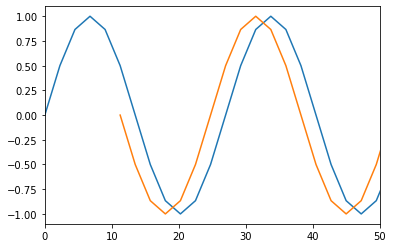

In [9]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*TR # seconds
Fs = 1/TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nperseg = n_trs_func - trs_exc_beg - trs_exc_end

f_lb = 0.02
f_ub = 0.15

print(hemi_freq)

t = np.arange(0.0, total_len, TR)
t_trim = np.arange((trs_exc_beg-1)*TR, (total_len - trs_exc_beg - trs_exc_end)+1, TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t_trim, hemi_alt_trim)

#### average the runs

In [33]:
masker = NiftiMasker(detrend=False, standardize="psc", mask_strategy="epi", high_pass=f_lb, low_pass=f_ub, t_r=TR) # 

In [34]:
masker.fit(bolds[0])

NiftiMasker(detrend=False, dtype=None, high_pass=0.02, low_pass=0.15,
            mask_args=None, mask_img=None, mask_strategy='epi',
            memory=Memory(location=None), memory_level=1, sample_mask=None,
            sessions=None, smoothing_fwhm=None, standardize='psc', t_r=2.25,
            target_affine=None, target_shape=None, verbose=0)

In [35]:
print(mask_file)

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz


In [36]:
!ls {mask_file}

ls: /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/sub-NB/sub-NB_ses-20191221_mask.nii.gz: No such file or directory


In [37]:
masker.mask_img_.to_filename(mask_file)

In [38]:
mask_img = masker.mask_img_
mask_img.shape

(128, 128, 21)

In [37]:
mean_bold_timeseries = utils.average_timeseries(bolds, masker)

0
(139, 77236, 2)
(139, 77236)
float32
[[ 0.0321  0.0232 -0.0163  0.0134  0.0208]
 [-0.3592 -0.1315  1.1612  0.2248 -0.3939]
 [-0.8028 -0.2203  1.8648 -0.3038  0.5137]
 [-1.2351 -0.1991  1.7815 -1.23    1.4267]
 [-0.4291 -0.3693  0.1891 -0.6622  0.8617]]
1
(139, 77236, 2)
(139, 77236)
float32
[[-3.3087e-02  2.9212e-02  6.8160e-02  3.4389e-03  8.0103e-03]
 [-7.5455e-01 -9.0122e-01 -1.2147e+00 -5.4151e-01 -1.3112e+00]
 [ 2.9798e-01 -3.5867e-03 -8.1606e-02 -4.2577e-01 -3.7341e-01]
 [ 1.8518e+00 -1.8708e+00 -2.2415e+00 -1.7217e+00 -1.8640e+00]
 [ 1.6619e-01 -4.0878e+00 -4.9455e+00 -2.7244e+00 -4.1076e+00]]


In [38]:
mean_bold_timeseries.shape

(139, 77236)

In [39]:
mean_bold_timeseries[:5, :5]

array([[-4.8196e-04,  2.6217e-02,  2.5934e-02,  8.4125e-03,  1.4422e-02],
       [-5.5688e-01, -5.1638e-01, -2.6768e-02, -1.5833e-01, -8.5252e-01],
       [-2.5240e-01, -1.1193e-01,  8.9159e-01, -3.6476e-01,  7.0148e-02],
       [ 3.0838e-01, -1.0349e+00, -2.2996e-01, -1.4759e+00, -2.1869e-01],
       [-1.3147e-01, -2.2285e+00, -2.3782e+00, -1.6933e+00, -1.6230e+00]])

In [40]:
hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=TR)

In [41]:
hemi_ts.shape, hemi_ts_trim.shape

((139,), (132,))

In [42]:
mean_bold_timeseries.shape

(139, 77236)

In [43]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

(132, 77236)

### begin coherence stuff

#### dummy stuff to see how coherence works

In [ ]:
timepad = np.pad(hemifield_alternation_sinusoid, (3,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad2 = np.pad(hemifield_alternation_sinusoid, (6,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]
timepad3 = np.pad(hemifield_alternation_sinusoid, (8,0), 'constant',
                 constant_values=(0,0))[:hemifield_alternation_sinusoid.shape[0]]

In [ ]:
fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
ax.plot(t, timepad)
ax.plot(t, timepad2)
ax.plot(t, timepad3)

#### analyze the real fmri data

In [44]:
masked_ts_flat = trim_bold_nm.T # want nvox, n_tp so transpose NiftiMasker result
#demean_ts_flat = demean.T

[ 11.25  13.5   15.75  18.    20.25  22.5   24.75  27.    29.25  31.5
  33.75  36.    38.25  40.5   42.75  45.    47.25  49.5   51.75  54.
  56.25  58.5   60.75  63.    65.25  67.5   69.75  72.    74.25  76.5
  78.75  81.    83.25  85.5   87.75  90.    92.25  94.5   96.75  99.
 101.25 103.5  105.75 108.   110.25 112.5  114.75 117.   119.25 121.5
 123.75 126.   128.25 130.5  132.75 135.   137.25 139.5  141.75 144.
 146.25 148.5  150.75 153.   155.25 157.5  159.75 162.   164.25 166.5
 168.75 171.   173.25 175.5  177.75 180.   182.25 184.5  186.75 189.
 191.25 193.5  195.75 198.   200.25 202.5  204.75 207.   209.25 211.5
 213.75 216.   218.25 220.5  222.75 225.   227.25 229.5  231.75 234.
 236.25 238.5  240.75 243.   245.25 247.5  249.75 252.   254.25 256.5
 258.75 261.   263.25 265.5  267.75 270.   272.25 274.5  276.75 279.
 281.25 283.5  285.75 288.   290.25 292.5  294.75 297.   299.25 301.5
 303.75 306.  ]


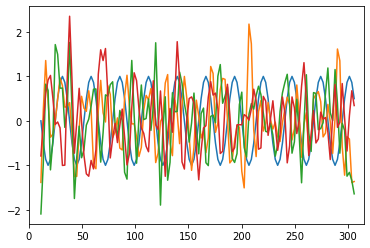

In [45]:
t=t_trim
print(t)
fig, ax = plt.subplots(1)
ax.set_xlim(0, 315)
ax.plot(t, hemi_alt_trim)
ax.plot(t, masked_ts_flat[32, :])
ax.plot(t, masked_ts_flat[3222, :])
ax.plot(t, masked_ts_flat[11513, :])
#ax.plot(t, masked_ts_flat[546434, :])

#### SpectralAnalyzer

In [46]:
bold_flat = ts.TimeSeries(masked_ts_flat[:, :], sampling_interval=TR)
#bold_flat = ts.TimeSeries(demean_ts_flat[:, :], sampling_interval=TR)

In [47]:
bold_flat.sampling_rate

0.4444444444444444 Hz

In [48]:
bold_flat.shape

(77236, 132)

In [49]:
assert(nperseg == masked_ts_flat.shape[-1])

In [50]:
S_original = nta.SpectralAnalyzer(bold_flat, method={'this_method':'welch', 'NFFT':nperseg, 'Fs':bold_flat.sampling_rate})

In [51]:
print(S_original)

SpectralAnalyzer(method={'this_method': 'welch', 'NFFT': 132, 'Fs': 0.4444444444444444 Hz}, BW=None, adaptive=False, low_bias=False)


In [52]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    ax01.plot(S_original.psd[0],
              S_original.psd[1][voxid],
              label='Welch PSD')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]))

    ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
    
    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [53]:
voxid = 144

[0.     0.0034 0.0067 0.0101 0.0135 0.0168 0.0202 0.0236 0.0269 0.0303
 0.0337 0.037  0.0404 0.0438 0.0471 0.0505 0.0539 0.0572 0.0606 0.064
 0.0673 0.0707 0.0741 0.0774 0.0808 0.0842 0.0875 0.0909 0.0943 0.0976
 0.101  0.1044 0.1077 0.1111 0.1145 0.1178 0.1212 0.1246 0.1279 0.1313
 0.1347 0.138  0.1414 0.1448 0.1481 0.1515 0.1549 0.1582 0.1616 0.165
 0.1684 0.1717 0.1751 0.1785 0.1818 0.1852 0.1886 0.1919 0.1953 0.1987
 0.202  0.2054 0.2088 0.2121 0.2155 0.2189 0.2222] [[1.1498e-02 5.4991e-03 1.3488e-05 ... 8.5122e-09 7.6498e-09 3.6911e-09]
 [3.4339e-02 1.9770e-02 6.3625e-05 ... 1.9655e-09 7.0360e-10 1.4219e-10]
 [8.8852e-02 4.5775e-02 1.0116e-05 ... 1.1300e-10 5.7194e-11 2.1108e-11]
 ...
 [1.9703e-01 1.0379e-01 2.0596e-04 ... 3.7549e-09 3.4955e-09 1.7058e-09]
 [4.1095e-03 2.6515e-03 7.3803e-05 ... 1.0833e-09 5.8701e-10 2.1287e-10]
 [7.7980e-03 3.1260e-03 9.6297e-05 ... 1.0455e-08 9.5432e-09 4.6213e-09]] 77236


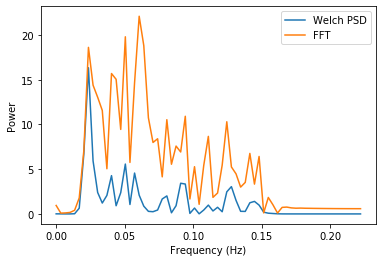

In [54]:
plot_spectra(S_original, voxid)

In [55]:
masked_ts_flat.shape

(77236, 132)

In [56]:
bold_flat.data.shape

(77236, 132)

In [57]:
def comparison_plots(masked_ts_flat, S_original, Fs, nperseg, voxid=1000):
    # Compute PSD with `scipy.signal.welch`
    f_welch, S_welch = scipy.signal.welch(
        masked_ts_flat[voxid, :], fs=Fs, nperseg=nperseg, noverlap=(nperseg // 2),
        detrend=None, scaling='density', window='hanning')

    # Compute PSD with `matplotlib.mlab.psd`, using parameters that are
    # *equivalent* to those used in `scipy.signal.welch` above
    S_mlab, f_mlab = mlab.psd(
        masked_ts_flat[voxid, :], Fs=Fs, NFFT=nperseg, noverlap=(nperseg // 2),
        detrend=None, scale_by_freq=True, window=mlab.window_hanning)

    fig, axes = plt.subplots(3, 1, sharex=True)

    # Plot PSD computed via both methods
    axes[0].plot(f_welch, S_welch, label='scipy.signal.welch')
    axes[0].plot(f_mlab, S_mlab, label='mlab.psd')
    axes[0].set_ylabel('PSD')
    axes[0].legend()

    axes[1].plot(S_original.spectrum_fourier[0],
                  np.abs(S_original.spectrum_fourier[1][voxid]),
                  label='nitime FFT')

    freqs2 = nitime.utils.get_freqs(Fs, masked_ts_flat.shape[-1])
    fft = scipy.fftpack.fft(bold_flat.data)
    scaledAmp = np.abs(fft[:, :freqs2.shape[0]])
    amp = 2*scaledAmp/masked_ts_flat.shape[-1]
    sqrtsummagsq = np.sqrt(np.sum(scaledAmp[:, :]**2))
    print(sqrtsummagsq)
    co = scaledAmp[:,11]/sqrtsummagsq;

    axes[1].plot(freqs2, scaledAmp[voxid], label='ScaledAmp')
    axes[2].plot(freqs2, amp[voxid], label='Amp')
    axes[2].set_xlabel('f')
    axes[1].legend()
    axes[2].legend()

    plt.suptitle(f"voxid {voxid}, co {co[voxid]}")
    plt.show()
    
    return [freqs2, amp, co]

18382.43807843337


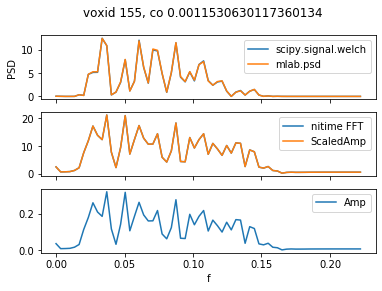

18382.43807843337


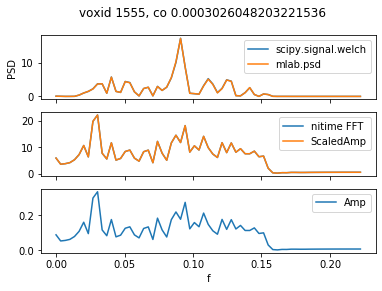

18382.43807843337


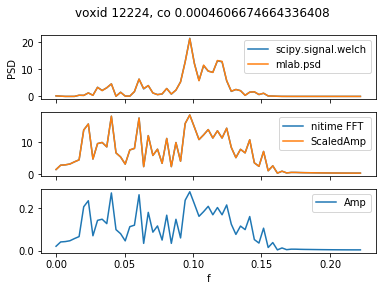

In [58]:
for v in [155, 1555, 12224]:
    _ = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, v)

18382.43807843337


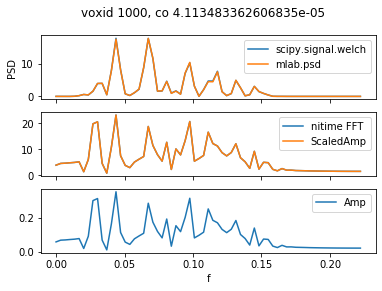

In [59]:
[f, a, co] = comparison_plots(masked_ts_flat, S_original, Fs, nperseg, 1000)

(array([31755., 32187.,  7433.,  1880.,  1040.,   761.,   709.,   619.,
          516.,   336.]),
 array([7.4954e-07, 4.8427e-04, 9.6779e-04, 1.4513e-03, 1.9348e-03,
        2.4183e-03, 2.9019e-03, 3.3854e-03, 3.8689e-03, 4.3524e-03,
        4.8359e-03]),
 <a list of 10 Patch objects>)

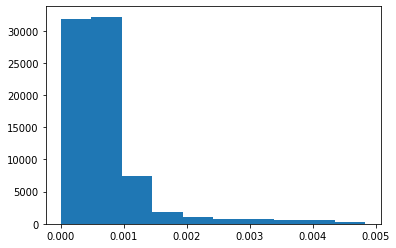

In [60]:
plt.hist(co)

In [61]:
coh_amp_map = masker.inverse_transform(co)

In [62]:
coh_amp_map.to_filename(coh_fn)

#### Correlation and Coherence

In [ ]:
full_stim = np.vstack((hemifield_alternation_sinusoid, masked_ts_flat[:1000,:]))

In [ ]:
full_stim.shape

In [ ]:
test_ts = ts.TimeSeries(full_stim, sampling_interval=TR)

In [ ]:
cr1 = nta.CorrelationAnalyzer(test_ts)
print(cr1.corrcoef)
ntv.drawmatrix_channels(cr1.corrcoef, color_anchor=0)

In [ ]:
ch1 = nta.CoherenceAnalyzer(test_ts)
#physiologically relevant freq band
freq_idx = np.where((ch1.frequencies > 0.02) * (ch1.frequencies < 0.15))[0]
coh = np.mean(ch1.coherence[:,:,freq_idx], -1)
coh

In [ ]:
fig03 = ntv.drawmatrix_channels(coh)

In [ ]:
ch1.phase[0,1]

#### SeedCoherenceAnalyzer

In [70]:
n_seeds = 1
A = nta.SeedCoherenceAnalyzer(hemi_ts_trim, bold_flat)#, method=dict(NFFT=32))
B = nta.SeedCorrelationAnalyzer(hemi_ts_trim, bold_flat)
freq_idx = np.where((A.frequencies > f_lb) * (A.frequencies < f_ub))[0]
#freq_idx_hemionly = np.where((np.isclose(A.frequencies, hemi_freq)))[0]
#print(freq_idx, freq_idx_hemionly)
print(A.frequencies, A.frequencies[freq_idx], f_lb, f_ub, sep="\n")
cor = []
coh = []

for this_seed in range(n_seeds):
    #print(this_seed, A.coherence[this_seed], A.coherence[this_seed][freq_idx])
    # Extract the coherence and average across these frequency bands:
    print(A.coherence.shape, A.coherence[:, :], A.coherence[:, freq_idx_hemionly], sep="\n")
    coh.append(np.mean(A.coherence[:, freq_idx], -1))  # Averaging on the last dimension
    cor.append(B.corrcoef[this_seed])  # No need to do any additional computation
        
print(f"coh: {coh}", f"cor: {cor}", sep="\n")

[0.     0.0069 0.0139 0.0208 0.0278 0.0347 0.0417 0.0486 0.0556 0.0625
 0.0694 0.0764 0.0833 0.0903 0.0972 0.1042 0.1111 0.1181 0.125  0.1319
 0.1389 0.1458 0.1528 0.1597 0.1667 0.1736 0.1806 0.1875 0.1944 0.2014
 0.2083 0.2153 0.2222]
[0.0208 0.0278 0.0347 0.0417 0.0486 0.0556 0.0625 0.0694 0.0764 0.0833
 0.0903 0.0972 0.1042 0.1111 0.1181 0.125  0.1319 0.1389 0.1458]
0.02
0.15
(77236, 33)
[[0.0058 0.0636 0.2659 ... 0.9053 0.9364 0.861 ]
 [0.0055 0.0809 0.6519 ... 0.5642 0.7819 0.8991]
 [0.0025 0.0563 0.3204 ... 0.6082 0.6372 0.6249]
 ...
 [0.001  0.0207 0.0985 ... 0.1367 0.0558 0.0162]
 [0.005  0.2075 0.4241 ... 0.7865 0.8507 0.8804]
 [0.0022 0.1722 0.4551 ... 0.371  0.5963 0.7173]]
[]
coh: [array([0.3666, 0.3575, 0.4991, ..., 0.2388, 0.4173, 0.3838])]
cor: [-0.03405461591659841]


In [65]:
len(coh[0])

77236

In [66]:
np.count_nonzero(coh[0])

77236

#### Write coherence values to Nifti file

In [79]:
coherence_img = masker.inverse_transform(coh[0])
coherence_img.shape

(128, 128, 21)

In [80]:
print(coh_fn)

/Users/smerdis/data/LGN/BIDS/NB_20191221/derivatives/streams/sub-NB_ses-20191221_task-hemi_desc-coherence_map.nii


In [81]:
coherence_img.to_filename(coh_fn)

In [82]:
!ls "{coh_fn}"

/Users/smerdis/data/LGN/BIDS/NB_20191221/derivatives/streams/sub-NB_ses-20191221_task-hemi_desc-coherence_map.nii


In [83]:
cmd = f"fsleyes {bolds[0]} {coh_fn}"

In [84]:
os.system(cmd)

0

#### Some visualizations

(array([   37.,  1127.,  7091., 18368., 23771., 17189.,  7402.,  1930.,
          289.,    32.]),
 array([0.0754, 0.1349, 0.1943, 0.2538, 0.3133, 0.3728, 0.4322, 0.4917,
        0.5512, 0.6106, 0.6701]),
 <a list of 10 Patch objects>)

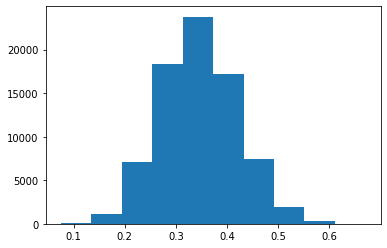

In [71]:
plt.hist(coh[0])

{'whiskers': [<matplotlib.lines.Line2D at 0x1c25fc7518>,
 'caps': [<matplotlib.lines.Line2D at 0x1c25fc7c18>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c25fc73c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c25fe32e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c25fe3630>],
 'means': []}

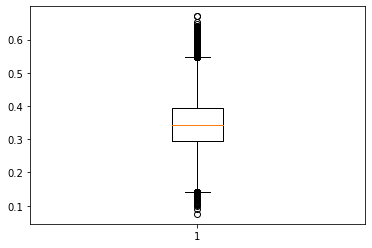

In [72]:
plt.boxplot(coh[0])

In [73]:
np.count_nonzero(coh[0]==0)

0

### Continue from here...

In [ ]:
lgn_coh_low = 0.17
lgn_coh_high = 0.19
lgn_voxel_mask_coh = np.logical_and((coh[0] > lgn_coh_low), (coh[0] < lgn_coh_high))

In [ ]:
np.count_nonzero(lgn_voxel_mask_coh)

## Assigning voxels within an ROI to M/P

In [ ]:
copefile = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_mp/hemifield/modelfit/datasink/stats_dir/_flameo2/stats/cope1.nii.gz'
ROIfile = mROI

In [ ]:
def assign_mp_command(cope, roimask, pct_thresh, roi_below, roi_above, out_dir=None):
    if out_dir is None:
        out_dir = os.path.dirname(roimask)
    print(f"python assign_mp.py {cope} {roimask} {pct_thresh} {roi_below} {roi_above} {out_dir}")

def assign_voxels(infile, rois, split_pct):
    """Assign voxels to an ROI based on the percentile of intensity they fall in.
    
    rois should be a list of length 2, split_pcts should be a list of length 1
    
    e.g. assign_voxels_percentile(infile, ['M', 'P'], 80)"""
    from nipype.interfaces.fsl import ImageMaths
    stats = ImageMaths()
    stats.inputs.in_file = infile
    stats.inputs.op_string = f"-thr {split_pct} -bin {roi_above}"
    print(stats.cmdline)

In [ ]:
assign_mp_command(copefile, ROIfile, 80, 'M', 'P')

In [ ]:
masked_cope = '/Users/smerdis/data/LGN/BIDS/MS_LGN_fp107/nipype_MS_20150401_hemi/hemifield/modelfit/datasink/cope_masked.nii.gz'

In [ ]:
assign_voxels_percentile(masked_cope, ['M', 'P'], 80)

## GLM

In [19]:
cmp, l2mp = utils.get_model_outputs(mp_datasink, [3])
mp_thresh = nilearn.image.threshold_img(l2mp[0], 2)


In [20]:
nilearn.plotting.view_img(l2mp[0], bg_img=ref_vol_path, threshold=2)

In [53]:
!ls /Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/ref_vol.nii

/Users/smerdis/data/LGN/BIDS/NB_20191221_odd/derivatives/streams/ref_vol.nii
